# Homework 4

### Problem 2

Dataset Structure:

Total Gaps, Gap#1, Gap#2, Gap#3, Gap#4, Gap#5

Gaps are in seconds. If a gap is not observed then the value for that column is set to -9.

In [1]:
import csv
from tabulate import tabulate
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np
from math import log

data = []
with open(r'gapdata.txt', 'r') as data_file:
    for row in csv.reader(data_file, delimiter='\t'):
        data.append(row)
data = np.array(data)

all_gaps = [[float(gap_) for gap_ in row if float(gap_) != -9] for row in data[:, 1:]]
critical_gap = [sum(gap_)/len(gap_) for gap_ in all_gaps]

In [2]:
for row in data:
    for r in row:
        if float(r) == 0:
            print(row)

['2' '10.5' '0' '-9' '-9' '-9' '-9']
['2' '18' '0' '-9' '-9' '-9' '-9']
['3' '5.5' '0' '0' '-9' '-9' '-9']
['3' '5.5' '0' '0' '-9' '-9' '-9']
['3' '9' '0.5' '0' '-9' '-9' '-9']
['3' '13' '5.5' '0' '-9' '-9' '-9']
['3' '30.5' '1.5' '0' '-9' '-9' '-9']
['6' '11.5' '1' '1' '0.5' '0.5' '0']
['4' '13.5' '3.5' '0.5' '0' '-9' '-9']
['6' '13' '3.5' '1' '1' '1' '0']
['2' '15.5' '0' '-9' '-9' '-9' '-9']
['3' '13.5' '9.5' '0' '-9' '-9' '-9']
['4' '18.5' '1.5' '1.5' '0' '-9' '-9']
['2' '12' '0' '-9' '-9' '-9' '-9']
['2' '10.5' '0' '-9' '-9' '-9' '-9']
['3' '22.5' '5' '0' '-9' '-9' '-9']
['3' '12.5' '2' '0' '-9' '-9' '-9']
['3' '8.5' '3.5' '0' '-9' '-9' '-9']


In [3]:
y = []
old_gap = []
gap = []
vehicle = []
crit_gap = []

for vid, row in enumerate(data):
    for i, in_row in enumerate(row[1:]):
        if float(in_row) > 0:
            vehicle.append(vid)
            y.append(1 if not i else 0)  # only the 2nd column contains accepted gap
            old_gap.append(float(in_row))
            gap.append(log(float(in_row)))
            crit_gap.append(log(critical_gap[vid]))

In [4]:
y = np.array(y)
gap = np.array(gap)
vehicle_id = np.array(vehicle)
crit_gap = np.array(crit_gap)

# Check if all variables are of the same length
len(y) == len(gap) and len(gap) == len(crit_gap) and len(crit_gap) == len(vehicle_id)

True

### Total number of gaps in the dataset

In [5]:
len(y)

418

### Response variables are Binary

$y \in \{ 0, 1 \} = \{ \text{"Rejected", "Accepeted"}\}$

### Explanatory Variables:
$x_1 = \text{log(Gap)}$

$x_2 = \text{Vehicle id}$

$x_3 = \text{Critical Gap   (Mean of valid gaps for a vehicle, -9 is an invalid gap)}$

# View of the Data (1st 20 datapoints)

In [6]:
dataset = [["y", "intercept (x0)", "Gap (not used)", "log Gap (x1)", "Vehicle id (x2)", "Critical Gap (x3)"]]
for i in range(20):
    dataset.append([y[i], 1, old_gap[i], gap[i], vehicle_id[i], crit_gap[i]])
print(tabulate(dataset, tablefmt='simple', stralign='center', headers="firstrow"))

  y    intercept (x0)    Gap (not used)    log Gap (x1)    Vehicle id (x2)    Critical Gap (x3)
---  ----------------  ----------------  --------------  -----------------  -------------------
  1                 1               3          1.09861                   0              1.15268
  0                 1               3.5        1.25276                   0              1.15268
  0                 1               3          1.09861                   0              1.15268
  1                 1               8.5        2.14007                   1              2.14007
  1                 1               6          1.79176                   2              1.79176
  1                 1              11.5        2.44235                   3              1.22867
  0                 1               6          1.79176                   3              1.22867
  0                 1               1          0                         3              1.22867
  0                 1               1   

In [7]:
x = np.array(list(zip(gap, vehicle_id, crit_gap)))

In [8]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [9]:
X = sm.add_constant(x)

In [10]:
def plot_roc_curve(fpr, tpr):
    fig, ax = plt.subplots(figsize=(12, 9))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_results(model, y, X):
    if model == "cloglog": 
        m = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.cloglog())).fit()
    else: 
        m = model(y, X).fit()
    print(m.summary2(), '\n')
    
    for i in [0.25, 0.50, 0.75]:
        y_hat = (m.predict(X) > i).astype('float')
        pt = confusion_matrix(y, y_hat, normalize=None)
        print(f"Confusion matrix for probability threshold = {i}:\n{pt}\n")
        dr = pt[1][1] / (pt[1][0] + pt[1][1])
        fp = pt[0][1] / (pt[0][0] + pt[0][1])
        print(f"Detection Rate = {pt[1][1]} / {(pt[1][0] + pt[1][1])}"
              f" = {round(dr, 2)}")
        print(f"False Positive Rate = {pt[0][1]} / {(pt[0][0] + pt[0][1])}"
              f" = {round(fp, 2)}\n\n")
    
    probs = m.predict(X)
    auc = roc_auc_score(y, probs)
    fpr, tpr, thresholds = roc_curve(y, probs)
    plot_roc_curve(fpr, tpr)
    
    print(f"Area Under Curve = {auc}")
    print('\n\n\n')
    return y_hat

Optimization terminated successfully.
         Current function value: 0.223208
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.678     
Dependent Variable: y                AIC:              194.6016  
Date:               2021-04-13 12:05 BIC:              210.7435  
No. Observations:   418              Log-Likelihood:   -93.301   
Df Model:           3                LL-Null:          -289.56   
Df Residuals:       414              LLR p-value:      9.2105e-85
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     -4.8304     0.6977   -6.9230   0.0000   -6.1979   -3.4629
x1         4.2505     0.4742    8.9632   0.0000    3.3210 

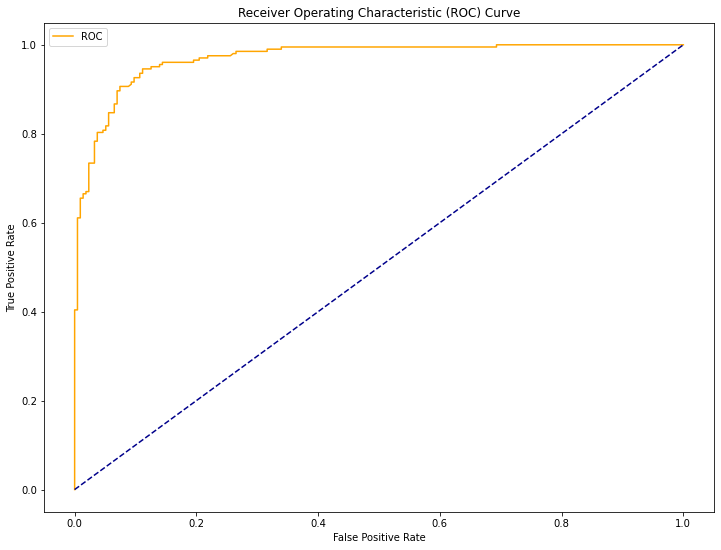

Area Under Curve = 0.9698018100584259






In [17]:
yhat = get_results(sm.Logit, y, X)

In [12]:
yhat

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 0.

In [13]:
yhat = np.array(yhat, dtype=int)

In [14]:
yhat

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,

In [15]:
y = np.array(y, dtype=int)

In [16]:
y

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,